# Module 4 - Classification Part I


In [674]:
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus 

from sklearn import tree
from scipy import stats
from IPython.display import Image

Gini coefficient @ $v_{i}$:

Gini coefficient $\in [0,1]$

$G(v_{i}) = 1 - \displaystyle \sum_{j=1}^k p_{j}^{2}$

$Overall G = \displaystyle \sum_{i=1}^r \displaystyle \frac{n_{i}G(v_{i})}{n}$

Entropy coefficent $\in [0, log_{2}k]$

$E(v_{i}) = - \displaystyle \sum_{j=1}^k p_{j}log_{2}(p_{j})$

$Overall E = \displaystyle \sum_{i=1}^r \displaystyle \frac{n_{i}E(v_{i})}{n}$

Reference: Shannon Entropy

$H(X) = - \displaystyle \sum_{i=1}^n P(x_{i})log_{2}P(x_{i})$

- Both Gini & Entropy have strongest discriminant power when they approach zero (0).

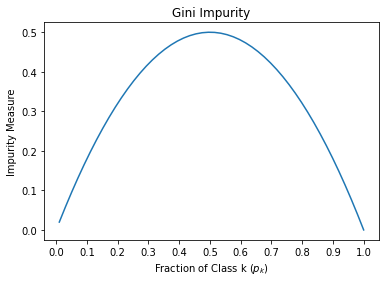

In [702]:
#A figure is created to show Gini ımpurity measures 
def plot_gini(x):
    plt.figure()
    # x = np.linspace(0.01,1)
    y = 1 - (x*x) - (1-x)*(1-x) 
    plt.plot(x,y)
    plt.title('Gini Impurity')
    plt.xlabel("Fraction of Class k ($p_k$)")
    plt.ylabel("Impurity Measure")
    plt.xticks(np.arange(0,1.1,0.1))

    plt.show()

plot_gini(np.linspace(0.01,1))    

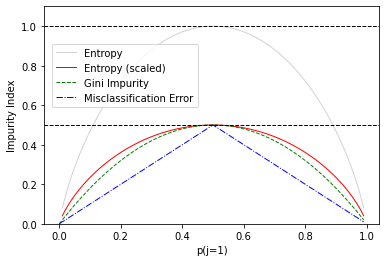

In [676]:
def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
scaled_ent = [e*0.5 if e else None for e in ent]
c_err = [classification_error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)

for j, lab, ls, c, in zip(
      [ent, scaled_ent, gini(x), c_err],
      ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
      ['-', '-', '--', '-.'],
      ['lightgray', 'red', 'green', 'blue']):
   line = ax.plot(x, j, label=lab, linestyle=ls, lw=1, color=c)

ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.85),
         ncol=1, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)')
plt.ylabel('Impurity Index')
plt.show()

In [282]:
def gini_impurity (value_counts):
    n = value_counts.sum()
    gini = 1
    
    if len(value_counts) == n:
        return 0
    
    for key in value_counts.keys():
        pj = value_counts[key]/n
        gini -= (pj)**2    
        
    return gini

def entropy(value_counts):
    entropy = 0
    for key in value_counts.keys():
        pj = value_counts[key]/n
        entropy += pj*math.log(pj,2)
    return -entropy

In [592]:
def get_gini_by_classes(dfs, feat_name, feat_unique_values, n):
    props = {}
    counts = {}
    for value in feat_unique_values:
        counts [value] = 0
        for key in dfs:
            df = dfs[key]
            if value not in props:
                props[value] = []
            props[value].append(len(df[df[feat_name] == value]))
            counts[value] += len(df[df[feat_name] == value])
            
    ginis = {}
    overall_g = 0
    for key in props:
        g = 1
        for val in props[key]:
            pj = val/sum(props[key])
            g -= pj**2
        ginis[key] = g
        ni = counts[key]
        overall_g += g*ni/n
    return ginis, overall_g

import math

def get_entropy(df, label_name):
    
    label_values = df[label_name].unique()
    counts = {}
    n = len(df)
    
    for val in label_values:
        counts[val] = len(df[df[label_name] == val])
#     print(label_values)
#     print(counts)
    
    e = 0
    for key in counts:
        val = counts[key]
        pj = val/n
        e -= pj*math.log(pj,2)
#     print(round(e,4))
    
    return e, counts

# information gain
def get_ig(df, label_name, feat_name):
    e, counts = get_entropy(df, label_name)
    feat_unique_values = df[feat_name].unique()    
    
    counts = {}
    n = len(df)
    
    for val in feat_values:
        counts[val] = len(df[df[feat_name] == val])
    
    dfs = {}
    for cls in classes:
        dfs[cls] = df[df[label_name] == cls]
    feat_props = {}
    feat_counts = {}
    for value in feat_unique_values:
        feat_counts [value] = 0
        for key in dfs:
            df = dfs[key]
            if value not in feat_props:
                feat_props[value] = []
            feat_props[value].append(len(df[df[feat_name] == value]))
            feat_counts[value] += len(df[df[feat_name] == value])
    
    print('feat_unique_values', feat_unique_values)
    print('feat_counts', feat_counts)
    e_split = 0
    for key in feat_counts:
        pi = feat_counts[key]/n
        ei = 0
        for count in feat_props[key]:                
            pj = count/sum(feat_props[key])
            if pj > 0:
                ei -= pj*math.log(pj,2)
            
        e_split += pi*ei
        print(f'{feat_counts[key]}: {e_split}')
    
    return e_split, e - e_split



In [686]:
filename = 'ex-3_2.csv'
label_name = 'Class'

# filename = 'ex-3_3.csv'
# label_name = 'Target_Class'

# filename = 'ex-3_6.csv'
# label_name = 'C1'

# filename = 'ex-3_extra.csv'
# label_name = 'default'

filename = 'vertebrate.csv'
label_name = 'Class'

df = pd.read_csv(filename)

df.style

## *** FOR ex-3_2.csv ONLY ***
### Begins

In [678]:
gender = {'M': 1, 'F': 2}
car_type = {'Family': 1, 'Sports': 2, 'Luxury': 3}
shirt_size = {'Small': 1, 'Medium':2, 'Large': 3, 'Extra Large': 4} # Preserving the order: Small, Medium, Large, Extra Lage ...
df = df.replace({'Gender': gender}).replace({'Car Type': car_type}).replace({'Shirt Size': shirt_size})
df

CustomerID  Gender  Car Type  Shirt Size Class
0            1       1         1           1    C0
1            2       1         2           2    C0
2            3       1         2           2    C0
3            4       1         2           3    C0
4            5       1         2           4    C0
5            6       1         2           4    C0
6            7       2         2           1    C0
7            8       2         2           1    C0
8            9       2         2           2    C0
9           10       2         3           3    C0
10          11       1         1           3    C1
11          12       1         1           4    C1
12          13       1         1           2    C1
13          14       1         3           4    C1
14          15       2         3           1    C1
15          16       2         3           1    C1
16          17       2         3           2    C1
17          18       2         3           2    C1
18          19       2         3           2    C1
19          20       2         3           3    C1

## *** FOR ex-3_2.csv ONLY ***
### Ends

## *** FOR vertebrate.csv ONLY ***
### Begins

In [687]:
## For data set `vertebrate.csv`, we are binarization the columns as follows:
df_old = df.copy(deep=True)
df['Class'] = df['Class'].replace(['fishes','birds','amphibians','reptiles'],'non-mammals')
df

Name  Warm-blooded  Gives Birth  Aquatic Creature  \
0           human             1            1                 0   
1          python             0            0                 0   
2          salmon             0            0                 1   
3           whale             1            1                 1   
4            frog             0            0                 1   
5          komodo             0            0                 0   
6             bat             1            1                 0   
7          pigeon             1            0                 0   
8             cat             1            1                 0   
9   leopard shark             0            1                 1   
10         turtle             0            0                 1   
11        penguin             1            0                 1   
12      porcupine             1            1                 0   
13            eel             0            0                 1   
14     salamander             0            0                 1   

    Aerial Creature  Has Legs  Hibernates        Class  
0                 0         1           0      mammals  
1                 0         0           1  non-mammals  
2                 0         0           0  non-mammals  
3                 0         0           0      mammals  
4                 0         1           1  non-mammals  
5                 0         1           0  non-mammals  
6                 1         1           1      mammals  
7                 1         1           0  non-mammals  
8                 0         1           0      mammals  
9                 0         0           0  non-mammals  
10                0         1           0  non-mammals  
11                0         1           0  non-mammals  
12                0         1           1      mammals  
13                0         0           0  non-mammals  
14                0         1           1  non-mammals

In [688]:
pd.crosstab([df['Warm-blooded'],df['Gives Birth']],df['Class'])

Class                     mammals  non-mammals
Warm-blooded Gives Birth                      
0            0                  0            7
             1                  0            1
1            0                  0            2
             1                  5            0

## *** FOR vertebrate.csv ONLY ***
### Ends

In [689]:
## Splitting data set into multiple data sets by values of the `label`.

classes = df[label_name].unique()
feat_list = df.columns.to_list()
feat_list.remove(label_name)

n = len(df)
dfs_by_classes = {}
for cls in classes:
    dfs_by_classes[cls] = df[df[label_name] == cls]

df_gini_output = pd.DataFrame()
dfs = []
for feat_name in feat_list:
    print(f'\n***{feat_name}***\n')
    feat_values = df[feat_name].unique()
    ginis, overall_g = get_gini_by_classes(dfs_by_classes, feat_name, feat_values, n)
    print('ginis:', ginis)
    print('overall G:', overall_g)
    dfs.append(pd.DataFrame([feat_name, ginis, overall_g]).transpose())    

df_gini_output = pd.concat(dfs)
df_gini_output.columns = ['Feature', 'G(vi)', 'G(S)']
display(df_gini_output)


***Name***

ginis: {'human': 0.0, 'python': 0.0, 'salmon': 0.0, 'whale': 0.0, 'frog': 0.0, 'komodo': 0.0, 'bat': 0.0, 'pigeon': 0.0, 'cat': 0.0, 'leopard shark': 0.0, 'turtle': 0.0, 'penguin': 0.0, 'porcupine': 0.0, 'eel': 0.0, 'salamander': 0.0}
overall G: 0.0

***Warm-blooded***

ginis: {1: 0.40816326530612246, 0: 0.0}
overall G: 0.1904761904761905

***Gives Birth***

ginis: {1: 0.2777777777777777, 0: 0.0}
overall G: 0.11111111111111108

***Aquatic Creature***

ginis: {0: 0.48979591836734704, 1: 0.21875}
overall G: 0.3452380952380953

***Aerial Creature***

ginis: {0: 0.4260355029585799, 1: 0.5}
overall G: 0.43589743589743585

***Has Legs***

ginis: {1: 0.48, 0: 0.31999999999999984}
overall G: 0.42666666666666664

***Hibernates***

ginis: {0: 0.4200000000000001, 1: 0.48}
overall G: 0.44000000000000006


Feature                                              G(vi)  \
0              Name  {'human': 0.0, 'python': 0.0, 'salmon': 0.0, '...   
0      Warm-blooded                   {1: 0.40816326530612246, 0: 0.0}   
0       Gives Birth                    {1: 0.2777777777777777, 0: 0.0}   
0  Aquatic Creature               {0: 0.48979591836734704, 1: 0.21875}   
0   Aerial Creature                    {0: 0.4260355029585799, 1: 0.5}   
0          Has Legs                  {1: 0.48, 0: 0.31999999999999984}   
0        Hibernates                   {0: 0.4200000000000001, 1: 0.48}   

       G(S)  
0       0.0  
0  0.190476  
0  0.111111  
0  0.345238  
0  0.435897  
0  0.426667  
0      0.44

In [690]:
e, counts = get_entropy(df, label_name)
print(f'E(S) = {round(e,4)}')
print('counts:', counts)


E(S) = 0.9183
counts: {'mammals': 5, 'non-mammals': 10}


In [691]:
for feat_name in df_gini_output['Feature']:
    print (f'\n---> IG for {feat_name}')
    e_split, ig = get_ig(df, label_name, feat_name)
    print(f'{feat_name}: e_split = {round(e_split,4)} & ig = {round(ig,4)}')
    



---> IG for Name
feat_unique_values ['human' 'python' 'salmon' 'whale' 'frog' 'komodo' 'bat' 'pigeon' 'cat'
 'leopard shark' 'turtle' 'penguin' 'porcupine' 'eel' 'salamander']
feat_counts {'human': 1, 'python': 1, 'salmon': 1, 'whale': 1, 'frog': 1, 'komodo': 1, 'bat': 1, 'pigeon': 1, 'cat': 1, 'leopard shark': 1, 'turtle': 1, 'penguin': 1, 'porcupine': 1, 'eel': 1, 'salamander': 1}
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
1: 0.0
Name: e_split = 0.0 & ig = 0.9183

---> IG for Warm-blooded
feat_unique_values [1 0]
feat_counts {1: 7, 0: 8}
7: 0.4027895986644278
8: 0.4027895986644278
Warm-blooded: e_split = 0.4028 & ig = 0.5155

---> IG for Gives Birth
feat_unique_values [1 0]
feat_counts {1: 6, 0: 9}
6: 0.26000896865934164
9: 0.26000896865934164
Gives Birth: e_split = 0.26 & ig = 0.6583

---> IG for Aquatic Creature
feat_unique_values [0 1]
feat_counts {0: 7, 1: 8}
7: 0.4597731301493174
8: 0.7496741665224356
Aquatic Creature: e_sp

# Decision Tree *** for ex-3_2.csv data set ***
## Gini Coefficient

In [684]:
Y = df['Class']
X = df.drop(['CustomerID','Class'],axis=1)

depth = 3
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=depth) # gini, entropy
clf = clf.fit(X, Y)

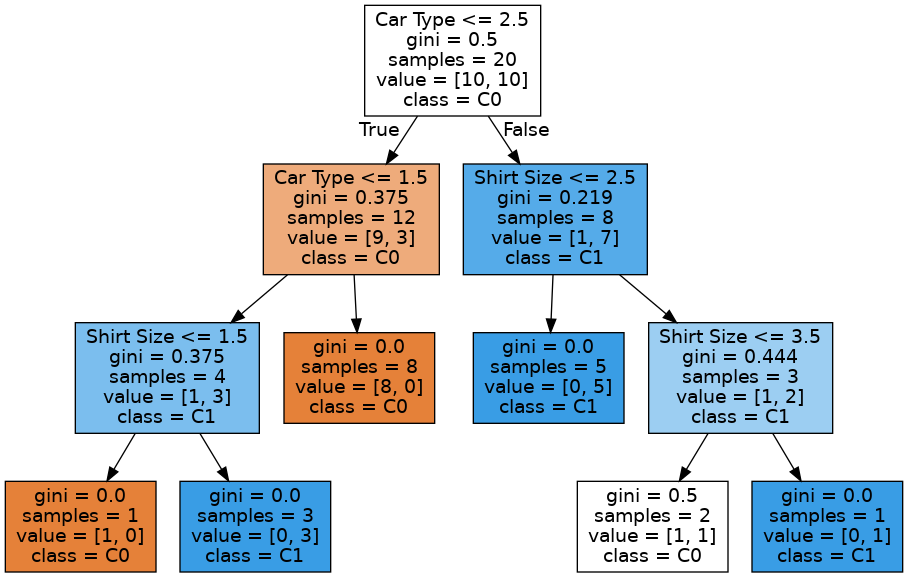

In [685]:
dot_data = tree.export_graphviz(clf, feature_names=X.columns, class_names=['C0','C1'], filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

# Decision Tree *** for vertebrate.csv data set ***
## Gini Coefficient

In [693]:
Y = df['Class']
X = df.drop(['Name','Class'],axis=1)

depth = 5
clf = tree.DecisionTreeClassifier(criterion='gini',max_depth=depth) # gini, entropy
clf = clf.fit(X, Y)
# display(X)
# display(Y)

## Graph the Tree


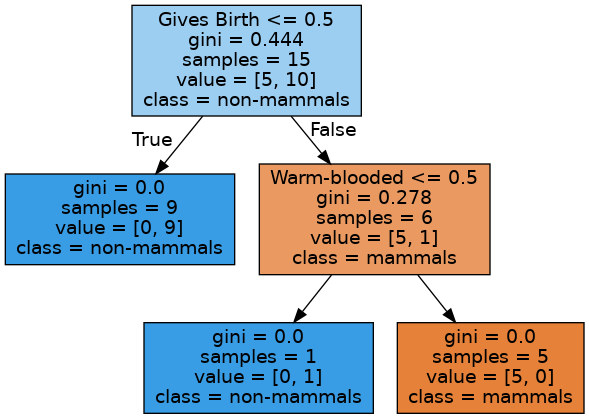

In [694]:
dot_data = tree.export_graphviz(clf, feature_names=X.columns, class_names=['mammals','non-mammals'], filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

## Entropy

In [696]:
Y = df['Class']
X = df.drop(['Name','Class'],axis=1)

depth = 5
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=depth) # gini, entropy
clf = clf.fit(X, Y)

## Graph the tree

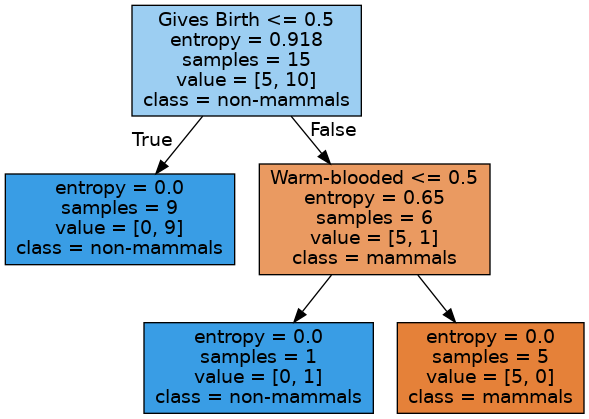

In [697]:
dot_data = tree.export_graphviz(clf, feature_names=X.columns, class_names=['mammals','non-mammals'], filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

## Testing the classifier


In [698]:
testData = [['gila monster',0,0,0,0,1,1,'non-mammals'],
           ['platypus',1,0,0,0,1,1,'mammals'],
           ['owl',1,0,0,1,1,0,'non-mammals'],
           ['dolphin',1,1,1,0,0,0,'mammals']]
testData = pd.DataFrame(testData, columns=df.columns)
testData

Name  Warm-blooded  Gives Birth  Aquatic Creature  Aerial Creature  \
0  gila monster             0            0                 0                0   
1      platypus             1            0                 0                0   
2           owl             1            0                 0                1   
3       dolphin             1            1                 1                0   

   Has Legs  Hibernates        Class  
0         1           1  non-mammals  
1         1           1      mammals  
2         1           0  non-mammals  
3         0           0      mammals

## Making Prediction on test data.

In [699]:
testY = testData['Class']
testX = testData.drop(['Name','Class'],axis=1)

predY = clf.predict(testX)
predictions = pd.concat([testData['Name'],pd.Series(predY,name='Predicted Class')], axis=1)
predictions

Name Predicted Class
0  gila monster     non-mammals
1      platypus     non-mammals
2           owl     non-mammals
3       dolphin         mammals

In [637]:
from sklearn.metrics import accuracy_score

print('Accuracy on test data is %.2f' % (accuracy_score(testY, predY)))

Accuracy on test data is 0.75
